In [191]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2 
from imageio import imread

In [192]:
def zero_padding(img, pad_w, pad_h):
    height, width = len(img), len(img[0])
    padded_height = height + 2 * pad_h
    padded_width = width + 2 * pad_w
    zero_padded_image = []

    for i in range(padded_height):
        row = []
        for j in range(padded_width):
            if i < pad_h or i >= pad_h + height or j < pad_w or j >= pad_w + width:
                row.append(0)
            else:
                row.append(img[i - pad_h][j - pad_w])
        zero_padded_image.append(row)

    zero_padded_image = np.array(zero_padded_image, dtype=np.float32)
    return zero_padded_image


In [193]:
def linear2D(img,filter_): 
    img_width , img_heigh = len(img[0]) , len(img)
    filter_width , filter_height = len(filter_[0]) ,len(filter_)
    width_padding , height_padding = filter_width//2 ,filter_height//2
    img = zero_padding(img,width_padding,height_padding)
    linear_img = []
    for i in range(height_padding,img_heigh+height_padding): 
        row = []
        for j in range(width_padding,img_width+width_padding): 
            summer = 0 
            for a in range(-width_padding,filter_width-width_padding): 
                for b in range(-height_padding,filter_height-height_padding): 
                    summer += img[i+b][j+a]*filter_[b+height_padding][a+width_padding]
            row.append(summer)
        linear_img.append(row)
    linear_img = np.array(linear_img) 
    return linear_img.astype(np.float32)

In [ ]:
def convolve(img, filter_):
    flipped_filter = np.flipud(np.fliplr(filter_))
    return linear2D(img, flipped_filter)

In [198]:
def convert_grayscale(img):
    red = img[:, :, 0].astype(np.float32)
    green = img[:, :, 1].astype(np.float32)
    blue = img[:, :, 2].astype(np.float32)
    luminance = 0.299 * red + 0.587 * green + 0.114 * blue
    return luminance / 255.0

In [199]:
def gaussian_kernel(size,sigma) -> np.ndarray:

    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)  # bruh level function
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))

    kernel /= np.sum(kernel)
    return kernel.astype(np.float32)

In [200]:
def downsample(img,downsampling_rate): 
    return img[::downsampling_rate,::downsampling_rate]

C:\Users\sasti\AppData\Local\Temp\ipykernel_31368\2030823227.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  loaded_image = imread('image.jpg')


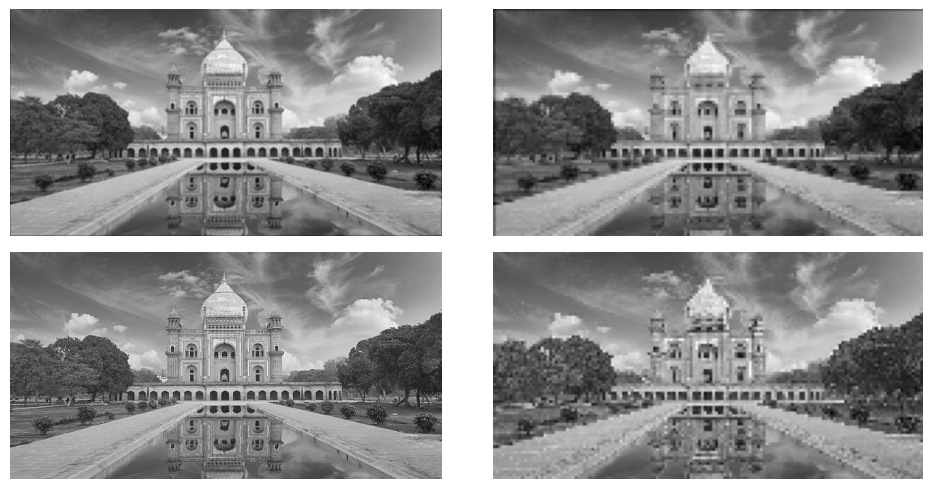

In [215]:
loaded_image = imread('image.jpg')
gray_scale = convert_grayscale(loaded_image)
zero_padded = zero_padding(gray_scale,10,10)
gaussian = gaussian_kernel(3,1.4)
gaussian_blur_img = convolve(gray_scale,gaussian)
fig , axis = plt.subplots(2,2,figsize = (10,5))
axis[0,0].imshow(gaussian_blur_img,cmap='gray')
axis[0,0].axis('off')
axis[1,0].imshow(gray_scale,cmap='gray')
axis[1,0].axis('off')
axis[0,1].imshow(downsample(gaussian_blur_img,4),cmap='gray')
axis[0,1].axis('off')
axis[1,1].imshow(downsample(gray_scale,4),cmap='gray')
axis[1,1].axis('off')
plt.tight_layout()
plt.show()

In [216]:
def sobel_filter(img,thresh_hold = 0):
    sobel_vert = np.array([[-1, -2, -1],
                           [ 0,  0,  0],
                           [ 1,  2,  1]], dtype=np.float32)
    sobel_hori = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]], dtype=np.float32)

    grad_x = convolve(img, sobel_hori)
    grad_y = convolve(img, sobel_vert)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    return grad_mag, grad_x, grad_y


In [219]:
import math 
def valid(x , y , size_x , size_y): 
    return x >= 0 and y >= 0 and x < size_x and y < size_y

def mag(a , b , x=0 , y=0): 
    return np.sqrt((a-x)**2 + (b-y)**2) 

def find_dir(angle):

    # prob the most shitiest code that man kind has ever seen before
    if angle < 22.5 : 
        return [[1,0],[-1,0]]
    elif angle < 67.5: 
        return [[1,1],[-1,-1]]
    elif angle < 115.5: 
        return [[0,1],[0,-1]]
    elif angle < 150.5: 
        return [[-1,1],[1,-1]]
    else: 
        return [[1,0],[-1,0]]


def non_maximum_supression(vert_img , hori_image): 
    width , height = len(vert_img[0]) , len(vert_img)
    max_gradient = [] 

    # get the max gradient direction and magnitude first
    gradient_peak = 0
    for i in range(height): 
        row = []
        for j in range(width):
            angle = abs(math.atan2(vert_img[i][j],hori_image[i][j])*(180/math.pi))
            dir = find_dir(angle)
            magnitude = mag(vert_img[i][j],hori_image[i][j])
            gradient_peak = max(magnitude , gradient_peak)
            row.append([magnitude,dir])

        max_gradient.append(row)

    # for each pixel go to the max_direction and compare its value (each pixel will have 2 directions to check)
    final_img = []
    for i in range(height): 
        row = []
        for j in range(width):
            is_highest = True
            for dir in max_gradient[i][j][1]: 
                nei_x = i + dir[0]
                nei_y = j + dir[1]
                if(valid(nei_x , nei_y , height , width)):
                    try:
                        if(max_gradient[nei_x][nei_y][0] > max_gradient[i][j][0]): 
                            is_highest = False 
                    except: 
                        print(nei_x , nei_y)
            if(is_highest and max_gradient[i][j][0] > 0.15*gradient_peak): 
                row.append(255)
            else: 
                row.append(0)
        final_img.append(row)
    return final_img

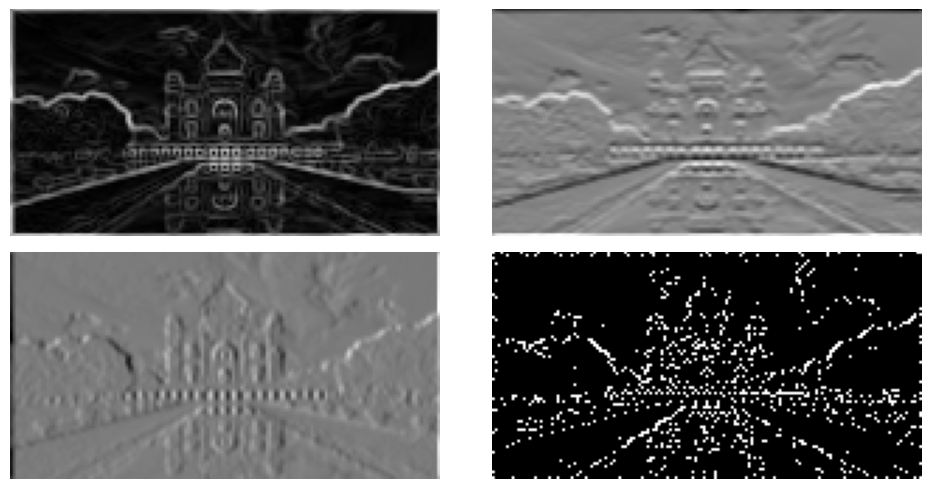

In [220]:
from imageio import imread
def increase_contrast(img):
    min_val = np.min(img)
    max_val = np.max(img)
    stretched = (img - min_val) * (255.0 / (max_val - min_val))
    return stretched.astype(np.uint8)
img = downsample(gaussian_blur_img,4)
m , h , v = sobel_filter(alpha)

fig , axis_ = plt.subplots(2,2,figsize = (10,5))

axis_[0,0].imshow(m,cmap='gray')
axis_[0,0].axis('off')
axis_[1,0].imshow(h,cmap='gray')
axis_[1,0].axis('off')
axis_[0,1].imshow(v,cmap='gray')
axis_[0,1].axis('off')
axis_[1,1].imshow(non_maximum_supression(v,h),cmap='gray')
axis_[1,1].axis('off')
plt.tight_layout()
plt.show()